/usr/local/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:111: RuntimeWarning: invalid value encountered in greater


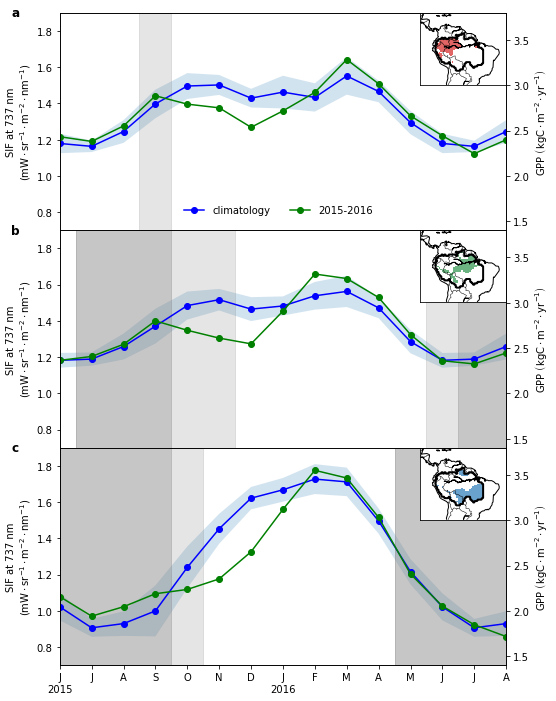

Carbon uptake anomaly for different regions
Region 			 Area (km2) 	 ΔC_OND (PgC) 		 ΔC_JFM (PgC)
--------------------------------------------------------------------------------------
Legal Amazon 		 7.05e+06 	 -0.63 (-12.5%) 	 0.07 (1.3%)
Everwet sub-region 	 1.96e+06 	 -0.13 (-8.7%) 		 0.005 (0.3%)
Wet sub-region 		 2.11e+06 	 -0.19 (-12.1%) 	 0.06 (3.5%)
Dry sub-region 		 2.54e+06 	 -0.29 (-16.1%) 	 -0.02 (-0.7%)


In [6]:
"""
Title: Amazon regions
Author: Gerbrand Koren
Date: February 18th, 2018
"""

#################################################
#                                               #
# INITIALIZE                                    #
#                                               #
################################################# 

# -- IPython settings
%reset -f
%matplotlib inline

# -- Import statements
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.image as image
import netCDF4 as nc
import pandas as pd
from mpl_toolkits.basemap import Basemap
from matplotlib.gridspec import GridSpec
import sys
import pickle

# -- Import custom functions
lib_path = '../../Library'
if not sys.path.count(lib_path):
    sys.path.insert(len(sys.path),lib_path)
import pyfunc as pf

# -- Output settings
save = False

#################################################
#                                               #
# INPUT                                         #
#                                               #
################################################# 

# ==== CONSTANTS

# -- Earth surface
A_earth = 510.1e6 # km2

# ==== SIF

# -- Dimensions
SIF_ntime = 120 # -
SIF_nlat = 360 # -
SIF_nlon = 720 # -

#################################################
#                                               #
# DATA IMPORT                                   #
#                                               #
#################################################

# ==== MASKS
 
# -- Load Amazon mask
g = nc.Dataset('amazon_mask.nc')
amazon = g.variables['regionmask'][:] # -
g.close()

# -- Koppen climate regions
q = nc.Dataset('koppen_regions.nc')
koppen = q.variables['regionmask'][:] # -
q.close()

# ==== GPP

# -- Load GPP variable
h = nc.Dataset('GPPdata_Beer_etal_2010_Science.nc')
GPP = h.variables['gpp'][:] # [latitude, longitude]
h.close()

# ==== SIF

# -- Directory
SIF_path = '/home/koren007/Data/180313_MONTHLY_SIFTER/'
SIF_path = '/home/chronos/user/Downloads/180313_MONTHLY_SIFTER/'

# -- Declare variables 
SIF_filenames = []

# -- Loop over years
for year in np.arange(10)+2007:
    
    # -- Loop over months
    for month in np.arange(12)+1:
        
        # -- Construct filenames        
        SIF_filenames.append('version_25_irr_corr_'+str(year)+'_l3_'+str(month).zfill(2)+'_'+str(year)+'.nc')
        
# -- Clear loop indices
del year, month

# -- Pre-allocation
SIF = np.zeros([SIF_ntime,SIF_nlat,SIF_nlon]) # W/sr/m2/nm

# -- Loop over files
for ii in np.arange(SIF_ntime):
    
    # -- Load SIF
    h = nc.Dataset(SIF_path+SIF_filenames[ii])
    SIF[ii,:,:] = h.variables['Chl_F_monthly_v2'][:] # [time, latitude, longitude]
    h.close()
    
# -- Clear loop index        
del ii
    
#################################################
#                                               #
# CALCULATION                                   #
#                                               #
#################################################

# ==== CONSTRUCT MASK

# -- Reverse latitudes
koppen = koppen[::-1,:] # -

# -- Increase resolution
amazon = pf.increase_resolution(amazon,SIF_nlat,SIF_nlon) # -
koppen = pf.increase_resolution(koppen,SIF_nlat,SIF_nlon) # -

# -- Select Amazon regions
rainforest_amazon = amazon*(koppen==1)
monsoon_amazon = amazon*(koppen==2)
savanna_amazon = amazon*(koppen==3)

# -- Determine color norm
region_norm = colors.Normalize(vmin=0.5,vmax=1.2)

# ==== GPP

# -- Convert to NumPy array
GPP = np.array(GPP) # gC/m2/yr
GPP[GPP==-9999] = 0.0 # gC/m2/yr

# -- Determine cell weight
cell_weight = pf.area_weighted(np.ones([SIF_nlat,SIF_nlon])) # -

# -- Mean GPP for different regions
GPP_amazon = np.sum(GPP*cell_weight*amazon)/(np.sum(cell_weight*amazon)) # gC/m2/yr

# ==== SIF TIME SERIES

# -- Convert unit
SIF = SIF*1.0e3 # mW/sr/m2/nm

# -- Determine mean SIF signals
SIF_amazon = np.zeros([SIF_ntime]) # [time]
SIF_rainforest = np.zeros([SIF_ntime]) # [time]
SIF_monsoon = np.zeros([SIF_ntime]) # [time]
SIF_savanna = np.zeros([SIF_ntime]) # [time]
for ii in np.arange(SIF_ntime):
    SIF_amazon[ii] = np.nansum(SIF[ii,:,:]*cell_weight*amazon)/(np.sum((1-np.isnan(SIF[ii,:,:]))*cell_weight*amazon)) # W/sr/m2/nm
    SIF_rainforest[ii] = np.nansum(SIF[ii,:,:]*cell_weight*rainforest_amazon)/(np.sum((1-np.isnan(SIF[ii,:,:]))*cell_weight*rainforest_amazon)) # W/sr/m2/nm
    SIF_monsoon[ii] = np.nansum(SIF[ii,:,:]*cell_weight*monsoon_amazon)/(np.sum((1-np.isnan(SIF[ii,:,:]))*cell_weight*monsoon_amazon)) # W/sr/m2/nm
    SIF_savanna[ii] = np.nansum(SIF[ii,:,:]*cell_weight*savanna_amazon)/(np.sum((1-np.isnan(SIF[ii,:,:]))*cell_weight*savanna_amazon)) # W/sr/m2/nm
del ii

# -- Detrended SIF time series
[slope,offset] = np.polyfit(np.arange(SIF_ntime),SIF_amazon,1) # [slope, offset]
SIF_amazon = SIF_amazon-slope*np.arange(SIF_ntime) # W/sr/m2/nm
SIF_rainforest = SIF_rainforest-slope*np.arange(SIF_ntime) # W/sr/m2/nm
SIF_monsoon = SIF_monsoon-slope*np.arange(SIF_ntime) # W/sr/m2/nm
SIF_savanna = SIF_savanna-slope*np.arange(SIF_ntime) # W/sr/m2/nm

# ==== ENSO ANOMALY

# -- Construct year and month
year = np.zeros(SIF_ntime) # -
month = np.zeros(SIF_ntime) # -
for ii in np.arange(10):
    for jj in np.arange(12):
        year[ii*12+jj] = ii+2007 # [time]
        month[ii*12+jj] = jj+1 # [time]
del ii, jj

# -- Amazon SIF climatology and ENSO anomaly
SIF_amazon_normal_mean = np.zeros(12) # [time]
SIF_amazon_normal_std = np.zeros(12) # [time]
SIF_amazon_2015 = np.zeros(12) # [time]
SIF_amazon_2016 = np.zeros(12) # [time]
for ii in np.arange(12):
    SIF_amazon_normal_mean[ii] = np.mean(SIF_amazon[np.logical_and.reduce(
        (year!=2010,year!=2015,year!=2016,month==ii+1))])
    SIF_amazon_normal_std[ii] = np.std(SIF_amazon[np.logical_and.reduce(
        (year!=2010,year!=2015,year!=2016,month==ii+1))])
    SIF_amazon_2015[ii] = np.mean(SIF_amazon[np.logical_and(year==2015,month==ii+1)])
    SIF_amazon_2016[ii] = np.mean(SIF_amazon[np.logical_and(year==2016,month==ii+1)])
del ii

# -- Rainforest SIF climatology and ENSO anomaly
SIF_rainforest_normal_mean = np.zeros(12) # [time]
SIF_rainforest_normal_std = np.zeros(12) # [time]
SIF_rainforest_2015 = np.zeros(12) # [time]
SIF_rainforest_2016 = np.zeros(12) # [time]
for ii in np.arange(12):
    SIF_rainforest_normal_mean[ii] = np.mean(SIF_rainforest[np.logical_and.reduce(
        (year!=2010,year!=2015,year!=2016,month==ii+1))])
    SIF_rainforest_normal_std[ii] = np.std(SIF_rainforest[np.logical_and.reduce(
        (year!=2010,year!=2015,year!=2016,month==ii+1))])
    SIF_rainforest_2015[ii] = np.mean(SIF_rainforest[np.logical_and(year==2015,month==ii+1)])
    SIF_rainforest_2016[ii] = np.mean(SIF_rainforest[np.logical_and(year==2016,month==ii+1)])
del ii

# -- Monsoon SIF climatology and ENSO anomaly
SIF_monsoon_normal_mean = np.zeros(12) # [time]
SIF_monsoon_normal_std = np.zeros(12) # [time]
SIF_monsoon_2015 = np.zeros(12) # [time]
SIF_monsoon_2016 = np.zeros(12) # [time]
for ii in np.arange(12):
    SIF_monsoon_normal_mean[ii] = np.mean(SIF_monsoon[np.logical_and.reduce(
        (year!=2010,year!=2015,year!=2016,month==ii+1))])
    SIF_monsoon_normal_std[ii] = np.std(SIF_monsoon[np.logical_and.reduce(
        (year!=2010,year!=2015,year!=2016,month==ii+1))])
    SIF_monsoon_2015[ii] = np.mean(SIF_monsoon[np.logical_and(year==2015,month==ii+1)])
    SIF_monsoon_2016[ii] = np.mean(SIF_monsoon[np.logical_and(year==2016,month==ii+1)])
del ii

# -- Savanna SIF climatology and ENSO anomaly
SIF_savanna_normal_mean = np.zeros(12) # [time]
SIF_savanna_normal_std = np.zeros(12) # [time]
SIF_savanna_2015 = np.zeros(12) # [time]
SIF_savanna_2016 = np.zeros(12) # [time]
for ii in np.arange(12):
    SIF_savanna_normal_mean[ii] = np.mean(SIF_savanna[np.logical_and.reduce(
        (year!=2010,year!=2015,year!=2016,month==ii+1))])
    SIF_savanna_normal_std[ii] = np.std(SIF_savanna[np.logical_and.reduce(
        (year!=2010,year!=2015,year!=2016,month==ii+1))])
    SIF_savanna_2015[ii] = np.mean(SIF_savanna[np.logical_and(year==2015,month==ii+1)])
    SIF_savanna_2016[ii] = np.mean(SIF_savanna[np.logical_and(year==2016,month==ii+1)])
del ii

# ==== SIF-GPP SCALING

# -- Determine SIF-GPP ratios
ratio_amazon = GPP_amazon/np.mean(SIF_amazon)/1.0e3 # (kgC/m2/yr)/(mW/sr/m2/nm)

# -- Cell area
A_cells = A_earth*cell_weight # km2

# -- Area of regions
A_amazon = np.sum(A_cells*amazon) # km2
A_rainforest = np.sum(A_cells*rainforest_amazon) # km2
A_monsoon = np.sum(A_cells*monsoon_amazon) # km2
A_savanna = np.sum(A_cells*savanna_amazon) # km2

# -- Climatological GPP
GPP_amazon_clim_OND = np.mean(SIF_amazon_normal_mean[9:])*ratio_amazon # kgC/m2/yr
GPP_amazon_clim_JFM = np.mean(SIF_amazon_normal_mean[:3])*ratio_amazon # kgC/m2/yr
GPP_rainforest_clim_OND = np.mean(SIF_rainforest_normal_mean[9:])*ratio_amazon # kgC/m2/yr
GPP_rainforest_clim_JFM = np.mean(SIF_rainforest_normal_mean[:3])*ratio_amazon # kgC/m2/yr
GPP_monsoon_clim_OND = np.mean(SIF_monsoon_normal_mean[9:])*ratio_amazon # kgC/m2/yr
GPP_monsoon_clim_JFM = np.mean(SIF_monsoon_normal_mean[:3])*ratio_amazon # kgC/m2/yr
GPP_savanna_clim_OND = np.mean(SIF_savanna_normal_mean[9:])*ratio_amazon # kgC/m2/yr
GPP_savanna_clim_JFM = np.mean(SIF_savanna_normal_mean[:3])*ratio_amazon # kgC/m2/yr

# -- ENSO GPP
GPP_amazon_2015_OND = np.mean(SIF_amazon_2015[9:])*ratio_amazon # kgC/m2/yr
GPP_amazon_2016_JFM = np.mean(SIF_amazon_2016[:3])*ratio_amazon # kgC/m2/yr
GPP_rainforest_2015_OND = np.mean(SIF_rainforest_2015[9:])*ratio_amazon # kgC/m2/yr
GPP_rainforest_2016_JFM = np.mean(SIF_rainforest_2016[:3])*ratio_amazon # kgC/m2/yr
GPP_monsoon_2015_OND = np.mean(SIF_monsoon_2015[9:])*ratio_amazon # kgC/m2/yr
GPP_monsoon_2016_JFM = np.mean(SIF_monsoon_2016[:3])*ratio_amazon # kgC/m2/yr
GPP_savanna_2015_OND = np.mean(SIF_savanna_2015[9:])*ratio_amazon # kgC/m2/yr
GPP_savanna_2016_JFM = np.mean(SIF_savanna_2016[:3])*ratio_amazon # kgC/m2/yr

# -- Anomaly in GPP
GPP_amazon_anom_OND = GPP_amazon_2015_OND-GPP_amazon_clim_OND # kgC/m2/yr
GPP_amazon_anom_JFM = GPP_amazon_2016_JFM-GPP_amazon_clim_JFM # kgC/m2/yr
GPP_rainforest_anom_OND = GPP_rainforest_2015_OND-GPP_rainforest_clim_OND # kgC/m2/yr
GPP_rainforest_anom_JFM = GPP_rainforest_2016_JFM-GPP_rainforest_clim_JFM # kgC/m2/yr
GPP_monsoon_anom_OND = GPP_monsoon_2015_OND-GPP_monsoon_clim_OND # kgC/m2/yr
GPP_monsoon_anom_JFM = GPP_monsoon_2016_JFM-GPP_monsoon_clim_JFM # kgC/m2/yr
GPP_savanna_anom_OND = GPP_savanna_2015_OND-GPP_savanna_clim_OND # kgC/m2/yr
GPP_savanna_anom_JFM = GPP_savanna_2016_JFM-GPP_savanna_clim_JFM # kgC/m2/yr

# -- Carbon uptake anomaly
carbon_amazon_anom_OND = GPP_amazon_anom_OND*3.0/12.0*A_amazon*1e-6 # PgC
carbon_amazon_anom_JFM = GPP_amazon_anom_JFM*3.0/12.0*A_amazon*1e-6 # PgC
carbon_rainforest_anom_OND = GPP_rainforest_anom_OND*3.0/12.0*A_rainforest*1e-6 # PgC
carbon_rainforest_anom_JFM = GPP_rainforest_anom_JFM*3.0/12.0*A_rainforest*1e-6 # PgC
carbon_monsoon_anom_OND = GPP_monsoon_anom_OND*3.0/12.0*A_monsoon*1e-6 # PgC
carbon_monsoon_anom_JFM = GPP_monsoon_anom_JFM*3.0/12.0*A_monsoon*1e-6 # PgC
carbon_savanna_anom_OND = GPP_savanna_anom_OND*3.0/12.0*A_savanna*1e-6 # PgC
carbon_savanna_anom_JFM = GPP_savanna_anom_JFM*3.0/12.0*A_savanna*1e-6 # PgC

# -- Relative uptake anomaly
rel_amazon_anom_OND = GPP_amazon_anom_OND/GPP_amazon_clim_OND*100.0 # %
rel_amazon_anom_JFM = GPP_amazon_anom_JFM/GPP_amazon_clim_JFM*100.0 # %
rel_rainforest_anom_OND = GPP_rainforest_anom_OND/GPP_rainforest_clim_OND*100.0 # %
rel_rainforest_anom_JFM = GPP_rainforest_anom_JFM/GPP_rainforest_clim_JFM*100.0 # %
rel_monsoon_anom_OND = GPP_monsoon_anom_OND/GPP_monsoon_clim_OND*100.0 # %
rel_monsoon_anom_JFM = GPP_monsoon_anom_JFM/GPP_monsoon_clim_JFM*100.0 # %
rel_savanna_anom_OND = GPP_savanna_anom_OND/GPP_savanna_clim_OND*100.0 # %
rel_savanna_anom_JFM = GPP_savanna_anom_JFM/GPP_savanna_clim_JFM*100.0 # %

#################################################
#                                               #
# RESULTS                                       #
#                                               #
################################################# 

# -- Set font settings
plt.rcParams['mathtext.default'] = 'regular'

# -- Create figure
fig = plt.figure(figsize=[8,12])
gs = GridSpec(3,1,height_ratios=[1,1,1])
gs.update(hspace=0.0)

# -- Plot SIF for rainforest
ax1 = fig.add_subplot(gs[0,0])
plt.plot(np.arange(15),np.append(SIF_rainforest_normal_mean[5:],
                                 SIF_rainforest_normal_mean[0:8]),'bo-',label='climatology')
plt.plot(np.arange(15),np.append(SIF_rainforest_2015[5:],
                                 SIF_rainforest_2016[0:8]),'go-',label='2015-2016')
plt.fill_between(np.arange(15),np.append(SIF_rainforest_normal_mean[5:]-SIF_rainforest_normal_std[5:],
                                         SIF_rainforest_normal_mean[0:8]-SIF_rainforest_normal_std[0:8]),
                 np.append(SIF_rainforest_normal_mean[5:]+SIF_rainforest_normal_std[5:],
                           SIF_rainforest_normal_mean[0:8]+SIF_rainforest_normal_std[0:8]),alpha=0.2)
plt.axvspan(2.5,3.5,color='grey',alpha=0.2)
plt.xlim(0,14)
plt.ylim(0.7,1.9)
plt.xticks(np.arange(15),[])
plt.ylabel('SIF at 737 nm\n'+r'$\left(mW\cdot sr^{-1}\cdot m^{-2}\cdot nm^{-1}\right)$')
plt.legend(loc=(0.27,0.05),frameon=False,ncol=2)
ax1.text(-0.1,1.0,'a',transform=ax1.transAxes,va='center',ha='center',weight='bold',size='large')

# -- Plot inset for rainforest location
plt.axes([0.75,0.763,0.15,0.15])
m = Basemap(projection='cyl',llcrnrlat=-30,urcrnrlat=20,llcrnrlon=-90,urcrnrlon=-30)
im = m.imshow(rainforest_amazon[120:220,180:300],alpha=0.7,interpolation='none',cmap='Reds',norm=region_norm)
im.cmap.set_under('white')
m.drawcoastlines()
m.drawcountries()
lons = np.ones([360,720])*(0.5*np.arange(720)-179.75)
lats = np.transpose(np.ones([720,360])*(0.5*np.arange(360)-89.75))
m.contour(lons,lats,amazon,1,linewidths=2,colors='k')

# --Add GPP axis for rainforest
ax1_GPP = ax1.twinx()
y1, y2 = ax1.get_ylim()
ax1_GPP.set_ylim(y1*ratio_amazon,y2*ratio_amazon)
ax1_GPP.set_ylabel(r'GPP $\left(kgC\cdot m^{-2}\cdot yr^{-1}\right)$')

# -- Plot SIF for monsoon
ax2 = fig.add_subplot(gs[1,0])
plt.plot(np.arange(15),np.append(SIF_monsoon_normal_mean[5:],
                                 SIF_monsoon_normal_mean[0:8]),'bo-',label='climatology')
plt.plot(np.arange(15),np.append(SIF_monsoon_2015[5:],
                                 SIF_monsoon_2016[0:8]),'go-',label='2015-2016')
plt.fill_between(np.arange(15),np.append(SIF_monsoon_normal_mean[5:]-SIF_monsoon_normal_std[5:],
                                         SIF_monsoon_normal_mean[0:8]-SIF_monsoon_normal_std[0:8]),
                 np.append(SIF_monsoon_normal_mean[5:]+SIF_monsoon_normal_std[5:],
                           SIF_monsoon_normal_mean[0:8]+SIF_monsoon_normal_std[0:8]),alpha=0.2)
plt.axvspan(0.5,3.5,color='grey',alpha=0.3)
plt.axvspan(12.5,14,color='grey',alpha=0.3)
plt.axvspan(0.5,5.5,color='grey',alpha=0.2)
plt.axvspan(11.5,14,color='grey',alpha=0.2)
plt.xlim(0,14)
plt.ylim(0.7,1.9)
plt.xticks(np.arange(15),[])
plt.ylabel('SIF at 737 nm\n'+r'$\left(mW\cdot sr^{-1}\cdot m^{-2}\cdot nm^{-1}\right)$')
ax2.text(-0.1,1.0,'b',transform=ax2.transAxes,va='center',ha='center',weight='bold',size='large')

# -- Plot inset for monsoon location
plt.axes([0.75,0.512,0.15,0.15])
m = Basemap(projection='cyl',llcrnrlat=-30,urcrnrlat=20,llcrnrlon=-90,urcrnrlon=-30)
im = m.imshow(monsoon_amazon[120:220,180:300],alpha=0.7,interpolation='none',cmap='Greens',norm=region_norm)
im.cmap.set_under('white')
m.drawcoastlines()
m.drawcountries()
lons = np.ones([360,720])*(0.5*np.arange(720)-179.75)
lats = np.transpose(np.ones([720,360])*(0.5*np.arange(360)-89.75))
m.contour(lons,lats,amazon,1,linewidths=2,colors='k')

# --Add GPP axis for monsoon
ax2_GPP = ax2.twinx()
y1, y2 = ax2.get_ylim()
ax2_GPP.set_ylim(y1*ratio_amazon,y2*ratio_amazon)
ax2_GPP.set_ylabel(r'GPP $\left(kgC\cdot m^{-2}\cdot yr^{-1}\right)$')

# -- Plot SIF for savanna
ax3 = fig.add_subplot(gs[2,0])
plt.plot(np.arange(15),np.append(SIF_savanna_normal_mean[5:],
                                 SIF_savanna_normal_mean[0:8]),'bo-',label='climatology')
plt.plot(np.arange(15),np.append(SIF_savanna_2015[5:],
                                 SIF_savanna_2016[0:8]),'go-',label='2015-2016')
plt.fill_between(np.arange(15),np.append(SIF_savanna_normal_mean[5:]-SIF_savanna_normal_std[5:],
                                         SIF_savanna_normal_mean[0:8]-SIF_savanna_normal_std[0:8]),
                 np.append(SIF_savanna_normal_mean[5:]+SIF_savanna_normal_std[5:],
                           SIF_savanna_normal_mean[0:8]+SIF_savanna_normal_std[0:8]),alpha=0.2)
plt.axvspan(0,3.5,color='grey',alpha=0.3)
plt.axvspan(10.5,14,color='grey',alpha=0.3)
plt.axvspan(0,4.5,color='grey',alpha=0.2)
plt.axvspan(10.5,14,color='grey',alpha=0.2)
plt.xlim(0,14)
plt.ylim(0.7,1.9)
plt.xticks(np.arange(15),['J\n2015','J','A','S','O','N','D','J\n2016','F','M','A','M','J','J','A'])
plt.ylabel('SIF at 737 nm\n'+r'$\left(mW\cdot sr^{-1}\cdot m^{-2}\cdot nm^{-1}\right)$')
ax3.text(-0.1,1.0,'c',transform=ax3.transAxes,va='center',ha='center',weight='bold',size='large')

# -- Plot inset for savanna location
plt.axes([0.75,0.26,0.15,0.15])
m = Basemap(projection='cyl',llcrnrlat=-30,urcrnrlat=20,llcrnrlon=-90,urcrnrlon=-30)
im = m.imshow(savanna_amazon[120:220,180:300],alpha=0.7,interpolation='none',cmap='Blues',norm=region_norm)
im.cmap.set_under('white')
m.drawcoastlines()
m.drawcountries()
lons = np.ones([360,720])*(0.5*np.arange(720)-179.75)
lats = np.transpose(np.ones([720,360])*(0.5*np.arange(360)-89.75))
m.contour(lons,lats,amazon,1,linewidths=2,colors='k')

# --Add GPP axis for savanna
ax3_GPP = ax3.twinx()
y1, y2 = ax3.get_ylim()
ax3_GPP.set_ylim(y1*ratio_amazon,y2*ratio_amazon)
ax3_GPP.set_ylabel(r'GPP $\left(kgC\cdot m^{-2}\cdot yr^{-1}\right)$')

# -- Save figure
if save == True:
    plt.savefig('Fig3.pdf',dpi=300,bbox_inches='tight')
else:
    plt.show()
    
# -- Carbon uptake anomaly for different regions
print 'Carbon uptake anomaly for different regions'
print '======================================================================================'
print 'Region \t\t\t Area (km2) \t ΔC_OND (PgC) \t\t ΔC_JFM (PgC)'
print '--------------------------------------------------------------------------------------'
print 'Legal Amazon \t\t %.2e \t %.2f (%.1f%%) \t %.2f (%.1f%%)' %(A_amazon,carbon_amazon_anom_OND,rel_amazon_anom_OND,carbon_amazon_anom_JFM,rel_amazon_anom_JFM)
print 'Everwet sub-region \t %.2e \t %.2f (%.1f%%) \t\t %.3f (%.1f%%)' %(A_rainforest,carbon_rainforest_anom_OND,rel_rainforest_anom_OND,carbon_rainforest_anom_JFM,rel_rainforest_anom_JFM) 
print 'Wet sub-region \t\t %.2e \t %.2f (%.1f%%) \t %.2f (%.1f%%)' %(A_monsoon,carbon_monsoon_anom_OND,rel_monsoon_anom_OND,carbon_monsoon_anom_JFM,rel_monsoon_anom_JFM) 
print 'Dry sub-region \t\t %.2e \t %.2f (%.1f%%) \t %.2f (%.1f%%)' %(A_savanna,carbon_savanna_anom_OND,rel_savanna_anom_OND,carbon_savanna_anom_JFM,rel_savanna_anom_JFM)
print '======================================================================================'
if save == True:
    oldstdout = sys.stdout
    sys.stdout = open('uptake.txt','w')
    print 'Carbon uptake anomaly for different regions'
    print '======================================================================================'
    print 'Region \t\t\t Area (km2) \t ΔC_OND (PgC) \t\t ΔC_JFM (PgC)'
    print '--------------------------------------------------------------------------------------'
    print 'Legal Amazon \t\t %.2e \t %.2f (%.1f%%) \t %.2f (%.1f%%)' %(A_amazon,carbon_amazon_anom_OND,rel_amazon_anom_OND,carbon_amazon_anom_JFM,rel_amazon_anom_JFM)
    print 'Everwet sub-region \t %.2e \t %.2f (%.1f%%) \t\t %.3f (%.1f%%)' %(A_rainforest,carbon_rainforest_anom_OND,rel_rainforest_anom_OND,carbon_rainforest_anom_JFM,rel_rainforest_anom_JFM) 
    print 'Wet sub-region \t\t %.2e \t %.2f (%.1f%%) \t %.2f (%.1f%%)' %(A_monsoon,carbon_monsoon_anom_OND,rel_monsoon_anom_OND,carbon_monsoon_anom_JFM,rel_monsoon_anom_JFM) 
    print 'Dry sub-region \t\t %.2e \t %.2f (%.1f%%) \t %.2f (%.1f%%)' %(A_savanna,carbon_savanna_anom_OND,rel_savanna_anom_OND,carbon_savanna_anom_JFM,rel_savanna_anom_JFM)
    print '======================================================================================'
    sys.stdout = oldstdout